In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import deque
from sklearn.decomposition import PCA

## Import course guide

In [3]:
hole_1 = cv2.imread("hul01.jpg")

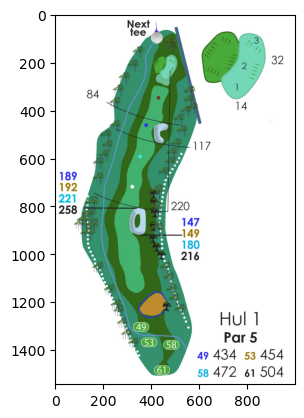

In [4]:
plt.imshow(hole_1)

## Define pixel length 

In [6]:
real_world_distance = 258 - 216  # in m
pixel_distance = 130       # measured manually
scale = real_world_distance / pixel_distance  # m per pixel

## Use KMeans to classify different areas of the hole

In [8]:
from sklearn.cluster import KMeans

In [9]:
pixels = hole_1.reshape(-1, 3)  # Shape: (num_pixels, 3)
kmeans = KMeans(n_clusters=11, random_state=0, n_init="auto").fit(pixels)

In [10]:
labels = kmeans.labels_.reshape(hole_1.shape[:2])

In [11]:
cluster_colors = kmeans.cluster_centers_.astype(int)

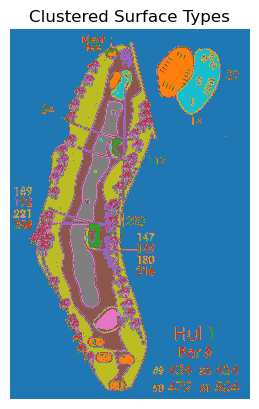

In [12]:
plt.imshow(labels, cmap='tab10')  # 'tab10' shows up to 10 color-coded clusters
plt.title("Clustered Surface Types")
plt.axis("off")
plt.show()

## Define each cluster

In [14]:
centers = kmeans.cluster_centers_.astype(int)

ob     = centers[0]
tee    = centers[1]
bunk   = centers[2]
tree   = centers[3]
rough  = centers[5]
wat   = centers[6]
fway = centers[7]
shit = centers[8]
green = centers[9]

In [15]:
masks = {
    "fairway": fway,
    "rough": rough,
    "bunker": bunk,
    "green": green,
    "water": wat,
    "ob": ob,
    "fescue": shit
}

## Find each teebox

In [17]:
label_map = labels.reshape(hole_1.shape[:2])  # shape (H, W)
teebox_mask = (label_map == 1)  # or whatever cluster index matches tee color

import cv2

# Convert boolean mask to uint8 for OpenCV
teebox_mask_uint8 = teebox_mask.astype(np.uint8) * 255

# Find connected components
num_labels, labels_im = cv2.connectedComponents(teebox_mask.astype(np.uint8) * 255)



In [18]:
height = hole_1.shape[0]
teebox_regions = []

for i in range(1, num_labels):  # skip background (label 0)
    component_mask = (labels_im == i)
    coords = np.column_stack(np.where(component_mask))
    
    # Get the average Y (vertical) position of the region
    avg_y = np.mean(coords[:, 0])  # row coordinate
    
    # Keep only regions near the bottom (e.g., bottom 30% of image)
    if avg_y > height * 0.7:
        teebox_regions.append(coords)


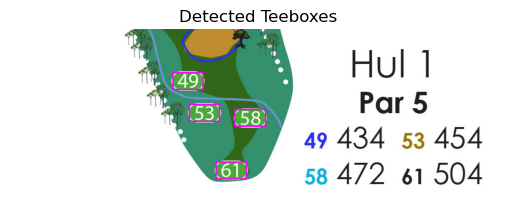

In [19]:
teebox_vis = hole_1.copy()
for region in teebox_regions:
    #print(region)
    if len(region) > 101:
        y_coords, x_coords = region[:, 0], region[:, 1]
        x_min, x_max = x_coords.min(), x_coords.max()
        y_min, y_max = y_coords.min(), y_coords.max()
        cv2.rectangle(teebox_vis, (x_min, y_min), (x_max, y_max), (255, 0, 255), 2)

plt.imshow(teebox_vis)
plt.title("Detected Teeboxes")
plt.axis("off")
plt.ylim(1550,1200)
plt.show()


## Driver distributions

/var/folders/48/ngfkp6gd3kq3j922jcx_zyhc0000gn/T/ipykernel_28264/339714974.py:10: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  shots = np.random.multivariate_normal(mu, cov, size=500)


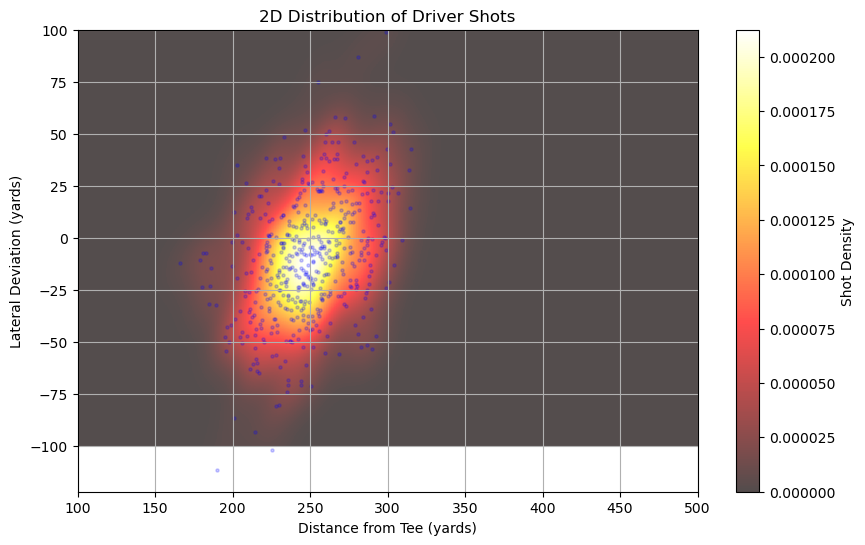

In [21]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

import numpy as np

# Simulate 500 driver shots: centered at (mu_x, mu_y) with some spread
mu = [250, -10]  # e.g., 300 yards forward, 50 yards left/right
cov = [[700, 700], [-300, 400]]  # wider spread left-right

shots = np.random.multivariate_normal(mu, cov, size=500)


# Transpose for KDE (scipy expects shape (2, N))
xy = shots.T
kde = gaussian_kde(xy)

# Create a grid to evaluate the KDE
xgrid = np.linspace(100, 500, 250)
ygrid = np.linspace(-100, 100, 300)
X, Y = np.meshgrid(xgrid, ygrid)
Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

# Plot the density
plt.figure(figsize=(10, 6))
plt.imshow(Z, origin='lower', aspect='auto',
           extent=[xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()],
           cmap='hot', alpha=0.7)
plt.colorbar(label="Shot Density")
plt.scatter(shots[:, 0], shots[:, 1], c='blue', s=5, alpha=0.2)
plt.title("2D Distribution of Driver Shots")
plt.xlabel("Distance from Tee (yards)")
plt.ylabel("Lateral Deviation (yards)")
plt.grid(True)
plt.show()


## Choose tee box

In [23]:
tee_pixel = np.flip(teebox_regions[-1][1])     # e.g., bottom-left starting point

tolerance = 15  # or smaller if needed
diff = np.abs(hole_1.astype(int) - tee)
mask = np.all(diff <= tolerance, axis=2)

massk = np.where(hole_1[0] == tee[0])
coords = np.column_stack(np.where(massk))

## Start overlay of shots

In [25]:
def yard_to_pixel(x_yard, y_yard, origin_pixel, scale):
    """
    Convert from (x, y) in yards to (x, y) in pixels.
    origin_pixel: pixel coordinates (px_x, px_y) of tee box
    scale: number of pixels per yard (e.g., 2.5 px/yard)
    """
    px_x = int(origin_pixel[0] + x_yard * scale)
    px_y = int(origin_pixel[1] - y_yard * scale)  # y flipped for image space
    return px_x, px_y

import random

random_shot = random.choice(shots)  # shape (2,) → (x, y)

(434, 1403)


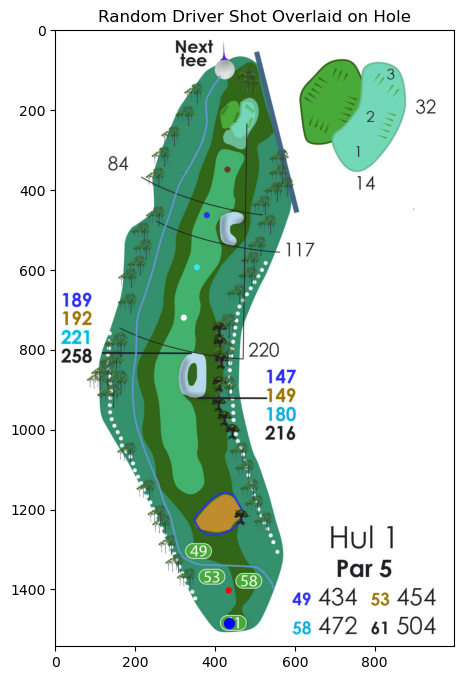

In [26]:
import cv2
import matplotlib.pyplot as plt


# Convert shot to pixel coordinates
shot_px = yard_to_pixel(random_shot[1], random_shot[0], tee_pixel, scale)
print(shot_px)

# Draw on the image (circle = driver shot)
img_with_shot = hole_1.copy()
cv2.circle(img_with_shot, shot_px, radius=8, color=(255, 0, 0), thickness=-1)


# Show the result
plt.figure(figsize=(10, 8))
plt.scatter(tee_pixel[0], tee_pixel[1], s = 50, color = 'blue')
plt.imshow(img_with_shot)
plt.title("Random Driver Shot Overlaid on Hole")
#plt.axis("off")
plt.show()


In [27]:
fairway_cluster = 2
green_cluster = 1
rough_cluster = 0
bunker_cluster = 4
tee_cluster = 3

In [28]:
label_map = labels.reshape(hole_1.shape[:2])
fairway_mask = (label_map == fairway_cluster)

# Get fairway pixel coordinates
fairway_pixels = np.column_stack(np.where(fairway_mask))  # (y, x) order
fairway_pixels = [(x, y) for y, x in fairway_pixels]  # convert to (x, y)



def get_aimpoint_at_distance(fairway_pixels, tee_pixel, scale_px_per_m, distance_m, y_tol=3):
    target_y = int(tee_pixel[1] - distance_m * scale_px_per_m)
    slice_pixels = [(x, y) for x, y in fairway_pixels if abs(y - target_y) <= y_tol]
    if not slice_pixels:
        return None
    avg_x = int(np.mean([x for x, _ in slice_pixels]))
    return (avg_x, target_y)


In [29]:
def simulate_driver_shots(aimpoint_px, scale_px_per_m, aim_x, aim_y, n=1, std_x=10, std_y=20):
    # Generate shot offsets in meters
    dx_m = np.random.normal(0, std_x, n)
    dy_m = np.random.normal(0, std_y, n)
    
    # Convert to pixels
    dx_px = dx_m * scale_px_per_m
    dy_px = dy_m * scale_px_per_m
    
    # Apply to aimpoint
    shots_px = np.column_stack([
        aimpoint_px[0] + dx_px - aim_x,
        aimpoint_px[1] + dy_px - aim_y
    ])

    aim_new = [aimpoint_px[0] - aim_x, aimpoint_px[1] - aim_y]
    
    return [shots_px.astype(int), aim_new]


In [30]:
def plot_shots_on_image(img, shots_px, aimpoint_px=None):
    img_copy = img.copy()

    # Draw shots as red dots
    for x, y in shots_px:
        if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
            cv2.circle(img_copy, (x, y), 2, (255, 0, 0), -1)

    # Draw aimpoint as green dot
    if aimpoint_px:
        cv2.circle(img_copy, aimpoint_px, 6, (0, 255, 0), -1)

    plt.figure(figsize=(12, 8))
    plt.imshow(img_copy)
    plt.scatter(tee_pixel[0], tee_pixel[1], s = 150, color = 'blue')
    plt.title("Driver Shot Distribution Overlaid on Image")
    #plt.axis("off")
    plt.show()


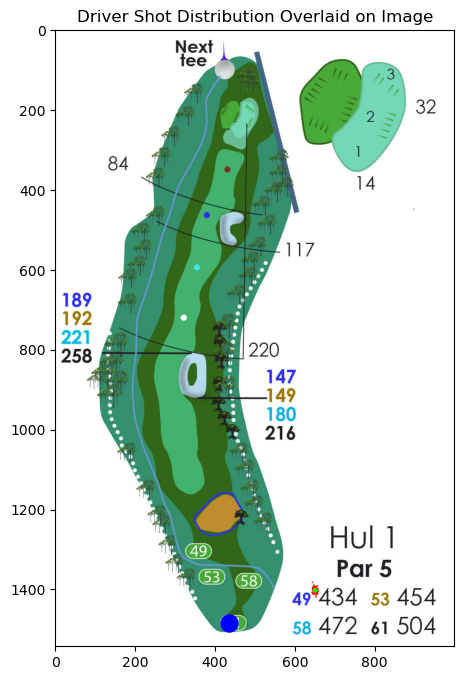

In [31]:

aimpoint = get_aimpoint_at_distance(fairway_pixels, tee_pixel, scale, distance_m=250)
driver_shots, new_aim = simulate_driver_shots(aimpoint, scale, 120, 0, n=1)
if aimpoint:
    driver_shots, new_aim = simulate_driver_shots(aimpoint, scale, 70, 0, n=100) #70 pix left of initial aim, 0 pix up/down of aimpoint
    #print(driver_shots)
    plot_shots_on_image(hole_1, driver_shots, new_aim)
else:
    print("Could not find a valid aimpoint.")


## Shots gained

In [33]:
# create some baseline for different lies

baseline_table = {
    "fairway": 1,
    "rough": 0.6,
    "bunker": 0.3,
    "fescue": 0.1,
    "green": 1.5,
    "ob": -2,
    "water": -1.5,
}

In [34]:
# define the lie
def get_lie(ds):
    for name, mask in masks.items():
    
        if abs(np.linalg.norm(masks['{}'.format(name)] - hole_1[ds[:,1], ds[:,0]])) < 5:
            return name
            
#Find distance to center of green
def dist_green(ds):
    return np.linalg.norm(green_center - ds)/scale
    

In [35]:
get_lie(driver_shots)

In [36]:
ys, xs = np.where(labels == 9)  # Get all green pixels

# Apply mask to exclude x-values > 500
ys, xs = np.where(labels == 9)  # Get coordinates of all green pixels

# Apply both filters
valid_mask = (xs <= 500) & (ys <= 300)

filtered_xs = xs[valid_mask]
filtered_ys = ys[valid_mask]


filtered_xs = xs[valid_mask]
filtered_ys = ys[valid_mask]

green_center = np.array([
    int(filtered_xs.mean()), 
    int(filtered_ys.mean())
])


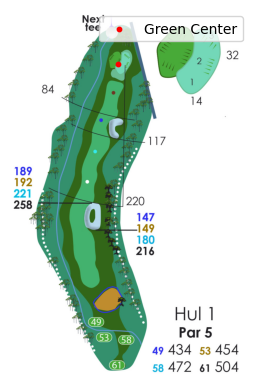

In [37]:
plt.imshow(hole_1)
plt.scatter(green_center[0], green_center[1], c='red', s=10, label='Green Center')
plt.legend()
#plt.title("Green Center on Hole Image")
plt.axis('off')
plt.show()


In [38]:
# create some sort of shots gained measurement
def sg(driver_shots):
    lie = get_lie(driver_shots)
    dist = dist_green(driver_shots)

    sg = dist/1000 * float(baseline_table[lie])

    return sg
    
    

In [39]:
k = 0
shots = []
sg1 = []
while k < 1000:
    aimpoint = get_aimpoint_at_distance(fairway_pixels, tee_pixel, scale, distance_m=250)
    shot, new_aim = simulate_driver_shots(aimpoint, scale, 100, 0, n=1)
    lie = (get_lie(shot))
    if lie in masks:
        #print(lie)
        #print(shot)
        sg1.append(sg(shot))
        shots.append(shot)
        k += 1

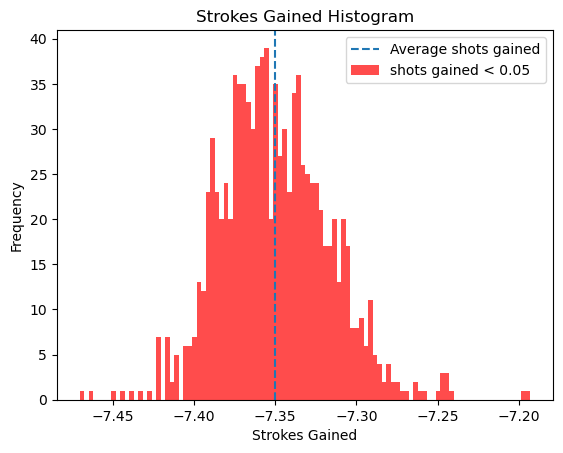

In [40]:
counts, bins = np.histogram(sg1, bins=100)

# Compute bin centers
bin_centers = 0.5 * (bins[:-1] + bins[1:])
width = bins[1] - bins[0]

# Draw bars with conditional colors

neg_labeled = False
pos_labeled = False

for c, x in zip(counts, bin_centers):
    if x < 0.05:
        if not neg_labeled:  # only add label once
            plt.bar(x, c, width=width, color="red", align="center", alpha=0.7, 
                    label='shots gained < 0.05')
            neg_labeled = True
        else:
            plt.bar(x, c, width=width, color="red", align="center", alpha=0.7)
    else:
        if not pos_labeled:  # only add label once
            plt.bar(x, c, width=width, color="green", align="center", alpha=0.7, 
                    label='shots gained > 0.05')
            pos_labeled = True
        else:
            plt.bar(x, c, width=width, color="green", align="center", alpha=0.7)

plt.title("Strokes Gained Histogram")
plt.xlabel("Strokes Gained")
plt.ylabel("Frequency")
plt.axvline(x = np.mean(sg1), ls = '--', label = 'Average shots gained')
plt.legend()
plt.show()

## All distances

In [42]:
club_distances = {
    "driver": 250,
    "3w": 230,
    "7w": 210,
    "4i": 190,
    "5i": 180,
    "6i": 170,
    "7i": 160,
    "8i": 150,
    "9i": 140,
    "pw": 130,
    "gw": 115,
    "sw": 105,
    "lw": 90
}

-1.7777777777777777
-0.4444444444444444
0.0
-1.1111111111111112


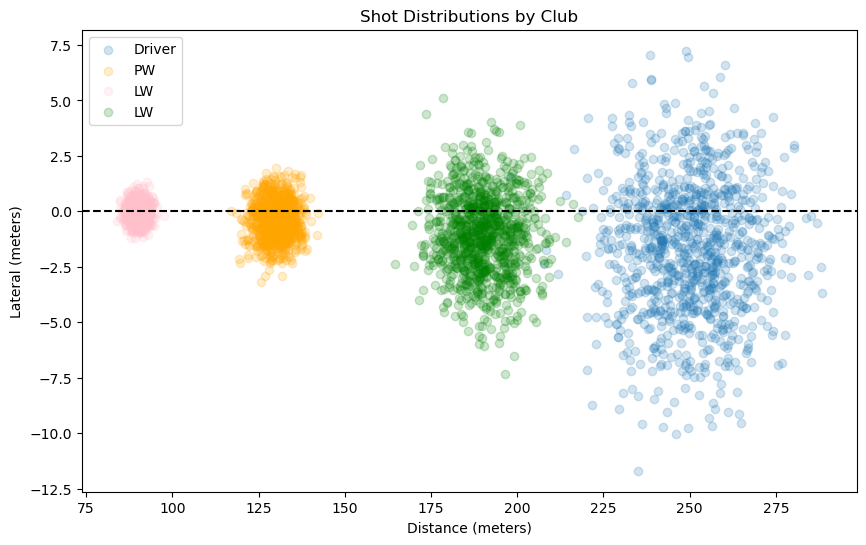

In [43]:
def simulate_shots(club, n=500):
    """Return 2D shot distribution for a given club."""
    mean_x = club_distances[club]
    mean_y =  - (club_distances[club] * 90 / 90**2) + 1
    print(mean_y)
    # Dispersion scaling: longer clubs = more spread
    base_std_x = 15  # longitudinal
    base_std_y = 30  # lateral
    
    # Scale dispersion by relative distance (driver widest, wedges tightest)
    scale = mean_x**2 / max(club_distances.values())**2  
    
    std_x = base_std_x * scale/1.1        # front/back miss
    std_y = base_std_y * scale/10        # left/right miss
    
    cov = [[std_x**2, 0],
           [0, std_y**2]]
    
    return np.random.multivariate_normal([mean_x, mean_y], cov, size=n)

# Example: simulate driver vs pitching wedge
driver_shots = simulate_shots("driver", n = 1000)
pw_shots = simulate_shots("pw", n = 1000)
lw_shots = simulate_shots("lw", n = 1000)
i4_shots = simulate_shots("4i", n = 1000)

plt.figure(figsize=(10,6))
plt.scatter(driver_shots[:,0], driver_shots[:,1], alpha=0.2, label="Driver")
plt.scatter(pw_shots[:,0], pw_shots[:,1], alpha=0.2, label="PW", color="orange")
plt.scatter(lw_shots[:,0], lw_shots[:,1], alpha=0.2, label="LW", color="pink")
plt.scatter(i4_shots[:,0], i4_shots[:,1], alpha=0.2, label="LW", color="green")
plt.axhline(0, color="k", linestyle="--")
plt.xlabel("Distance (meters)")
plt.ylabel("Lateral (meters)")
plt.title("Shot Distributions by Club")
plt.legend()
plt.show()